In [1]:
!pip -q install pandas sklearn matplotlib

You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


2022-02-27 09:52:21.829179: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-27 09:52:21.844098: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-27 09:52:21.844560: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-27 09:52:21.846760: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-27 09:52:21.847165: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read f

Root Mean Squared Error is 0.33549299512593783


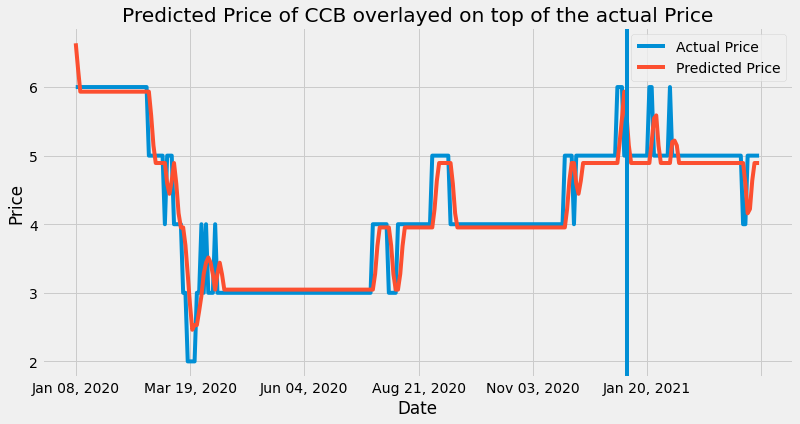

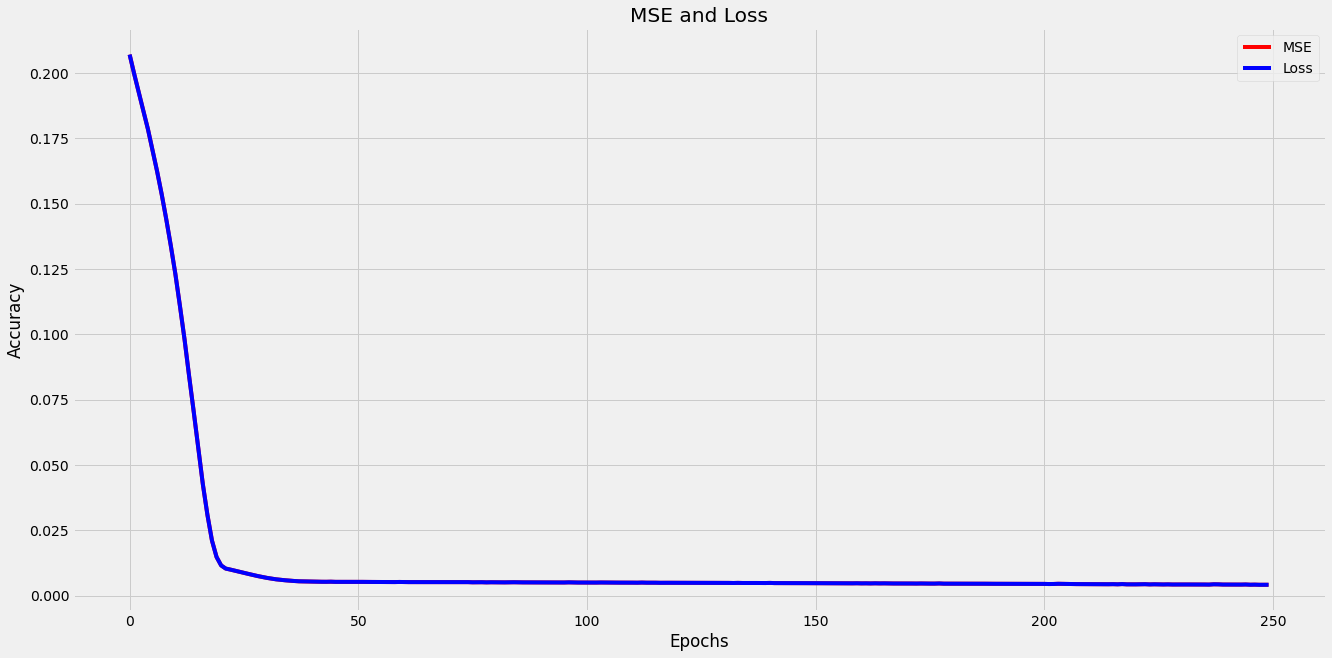

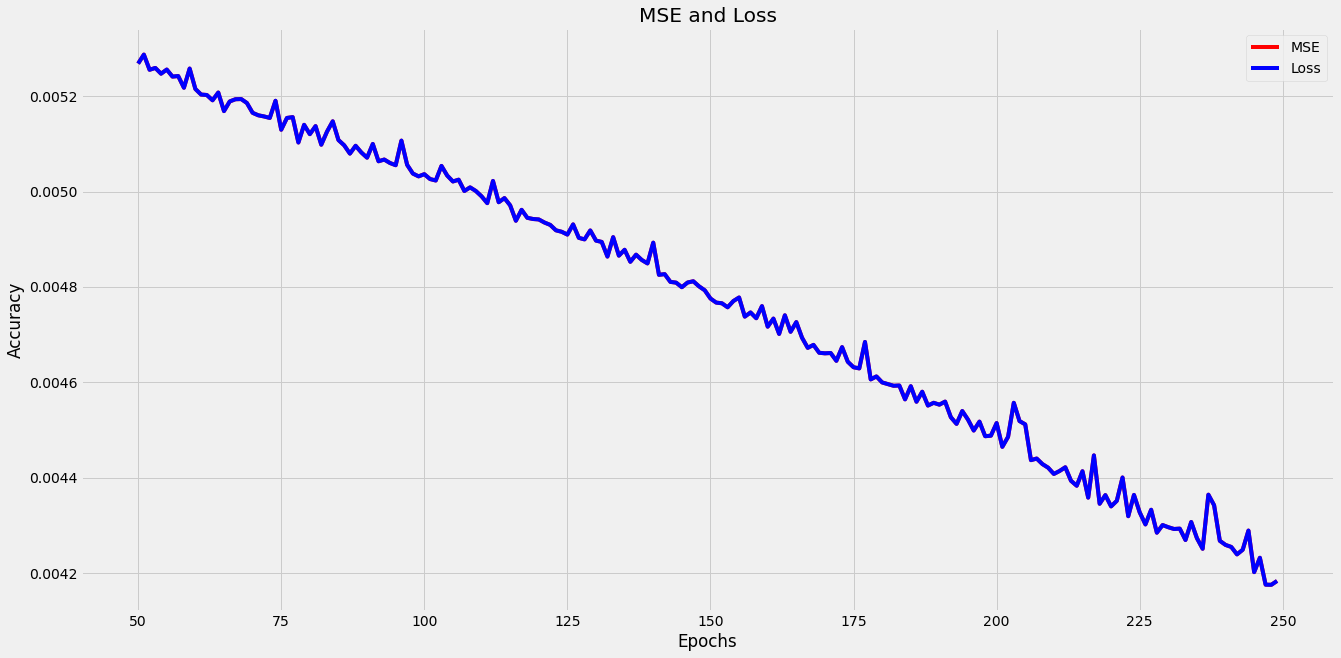

<Figure size 1440x720 with 0 Axes>

In [2]:
#dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import os
from pathlib import Path
import requests
import math
from termcolor import colored as cl 
import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (20, 10)

#global variables
n_steps = 3
n_features = 1

#importing the dataset
df = pd.read_csv('daily_stock_prices/CCB.csv', index_col='Date', parse_dates=True)
df = df[:-1] #deleting the last row as it is just providing statistics
df = df[::-1] #sorting the order so that 2020 appears first
df = df.reset_index()
    
#dropping volume and change % as they will not be used for the prediction
df = df.drop(columns = ['Vol.', 'Change %'])
    
#checking for null values
null_values = df.isnull().values.any()
if null_values:
    df = df.dropna(axis=0)
    
#removing comma
df['Price'] = df['Price'].str.extract(r'([^,]+)')
df['Open'] = df['Open'].str.extract(r'([^,]+)')
df['High'] = df['High'].str.extract(r'([^,]+)')
df['Low'] = df['Low'].str.extract(r'([^,]+)')
    
#changing dtype of columns to float
df['Price'] = pd.to_numeric(df['Price'])
df['Open'] = pd.to_numeric(df['Open'])
df['High'] = pd.to_numeric(df['High'])
df['Low'] = pd.to_numeric(df['Low'])

date_arr = df['Date'].to_numpy() #storing date as we would need this at a later point

#goal here is to split the data into train and test dataframe using end of 2020 as the boundary to slice the dataframe
#finding the train-test boundary
df['Year'] = pd.DatetimeIndex(df['Date']).year
train_test_boundary = df[df['Year'] == 2020].index[-1] #extracting the index of where 2020 data finishes
    
#setting date as index
df = df.set_index('Date')
    
#removing the Year column
df = df.drop(columns = ['Year'])
    
#normalize the data
scaler = MinMaxScaler()
cols = df.columns
df[cols] = scaler.fit_transform(df[cols])
        
#defining the training dataframe
train_df = df[:train_test_boundary]
    
#defining the testing dataframe
test_df = df[train_test_boundary:]

# split a univariate sequence into samples
# for example if we had a data such as [10, 20, 30, 40, 50]
# and if n_step was 3
# then feature will be [[10, 20, 30], [20, 30, 30]]
# and label will be [[40], [50]]
# logic of this approach can be found here - machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting
def split_sequence(data, n_steps):
    X, y = list(), list()
    for i in range(len(data)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(data)-1:
            break
        # gather input and output parts of the pattern
        seq_x_price = data['Price'].iloc[i:end_ix]
        seq_y = data['Price'].iloc[end_ix]
        x = np.empty((3,n_features))
        for idx in range(n_steps):
            x[idx, 0] = seq_x_price[idx]
        y.append(seq_y)
        X.append(x)
    return np.array(X), np.array(y)

tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

#creating training set and labels with a n_step of 3
X_train, y_train = split_sequence(train_df, n_steps)
    
#creating training set and labels with a n_step of 3
X_test, y_test = split_sequence(test_df, n_steps)
    
# define model
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(256, activation='relu', input_shape=(n_steps, n_features), return_sequences=True))
model.add(tf.keras.layers.LSTM(64, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='mse', metrics=['mse'])
    
# reshape from [samples, timesteps] into [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], n_features)
    
# fit model
history = model.fit(X_train, y_train, epochs=250, verbose=0, validation_data = (X_test, y_test))
    
#generating the predicted array using model.predict
forecast = []
y_hat = []

for time in range (len(df) - n_steps):
    X = df['Price'].to_numpy()
    pred = model.predict(X[time:time+n_steps].reshape(1,3,1))
    forecast.append(pred)

y_hat = np.array(forecast)

y_hat = np.append(y_hat[:, 0], np.zeros((y_hat[:, 0].shape[0], 3)), axis=1) 
y_hat = scaler.inverse_transform(y_hat) #converting the normalized data back to its orginal 

df = scaler.inverse_transform(df)

df_final = pd.DataFrame()
df_final['Actual Price'], df_final['Predicted Price'], df_final["Date"] = df[3:, 0], y_hat[:, 0], date_arr[3:]
df_final = df_final.set_index('Date')
    
title = 'Predicted Price of ' + Path('daily_stock_prices/CCB.csv').stem + ' overlayed on top of the actual Price'
ax = df_final[['Actual Price','Predicted Price']].plot(figsize=(12,6),title=title)
ax.autoscale(axis='Date',tight=True)
ax.set(ylabel='Price')
plt.axvline(x=train_test_boundary) #marks the boundary of training and test data

plt.figure()

mse=history.history['mse']
loss=history.history['loss']

epochs=range(len(loss))

plt.plot(epochs, mse, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MSE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MSE", "Loss"])

plt.figure()

epochs_zoom = epochs[50:]
mse_zoom = mse[50:]
loss_zoom = loss[50:]

plt.plot(epochs_zoom, mse_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MSE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MSE", "Loss"])

plt.figure()

#calculate rmse
from sklearn.metrics import mean_squared_error
from math import sqrt
df_final = df_final.dropna(axis=0)
rmse = sqrt(mean_squared_error(df_final['Actual Price'], df_final['Predicted Price']))
print("Root Mean Squared Error is", rmse)

df_final_copy = df_final

In [3]:
#bollinger bands calculation
def sma(data, window):
    sma = data.rolling(window = window).mean()
    return sma

def bb(data, sma, window):
    std = data.rolling(window = window).std()
    upper_bb = sma + std * 2
    lower_bb = sma - std * 2
    return upper_bb, lower_bb

def implement_bb_strategy(data, lower_bb, upper_bb):
    buy_price = []
    sell_price = []
    bb_signal = []
    signal = 0
    
    for i in range(1, len(data)):
        if data.iloc[i-1] > lower_bb.iloc[i-1] and data.iloc[i] < lower_bb.iloc[i]:
            if signal != 1:
                buy_price.append(data.iloc[i])
                sell_price.append(np.nan)
                signal = 1
                bb_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
        elif data.iloc[i-1] < upper_bb.iloc[i-1] and data.iloc[i] > upper_bb.iloc[i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(data.iloc[i])
                signal = -1
                bb_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            bb_signal.append(0)
            
    return buy_price, sell_price, bb_signal

In [4]:
investment_returns = []
sma_params = []
bb_params = []
        
for sma_param in np.linspace(10, 100, 10).astype(int):
    df_final = df_final_copy
    df_final['sma_20'] = sma(df_final['Predicted Price'], sma_param)
    for bb_param in np.linspace(10, 100, 10).astype(int):
        df_final['upper_bb'], df_final['lower_bb'] = bb(df_final['Predicted Price'], df_final['sma_20'], bb_param)
        buy_price, sell_price, bb_signal = implement_bb_strategy(df_final['Predicted Price'], df_final['lower_bb'], df_final['upper_bb'])
        buy_price.insert(0, None)
        sell_price.insert(0, None)
        bb_signal.insert(0, None)

        position = []
        for i in range(len(bb_signal)):
            if bb_signal[i] == None:
                position.append(None)
                continue
            if bb_signal[i] > 1:
                position.append(0)
            else:
                position.append(1)

        for i in range(len(df_final['Predicted Price'])):
            if bb_signal[i] == None:
                continue
            if bb_signal[i] == 1:
                position[i] = 1
            elif bb_signal[i] == -1:
                position[i] = 0
            else:
                position[i] = position[i-1]

        upper_bb = df_final['upper_bb']
        lower_bb = df_final['lower_bb']
        close_price = df_final['Predicted Price']
        bb_signal = pd.DataFrame(bb_signal).rename(columns = {0:'bb_signal'}).set_index(df_final.index)
        position = pd.DataFrame(position).rename(columns = {0:'bb_position'}).set_index(df_final.index)

        frames = [close_price, upper_bb, lower_bb, bb_signal, position]
        strategy = pd.concat(frames, join = 'inner', axis = 1)

        #backtesting on actual price
        price_diff = np.diff(df_final['Actual Price'])
        list(price_diff).insert(0, None)
        df_final_ret = pd.DataFrame(price_diff).rename(columns = {0:'returns'})
        bb_strategy_ret = []

        for i in range(len(df_final_ret)):
            try:
                returns = df_final_ret['returns'][i]*strategy['bb_position'][i]
                bb_strategy_ret.append(returns)
            except:
                bb_strategy_ret.append(np.nan)

        bb_strategy_ret.insert(0, None)
        bb_strategy_ret_df = pd.DataFrame(bb_strategy_ret).rename(columns = {0:'bb_returns'})
        bb_strategy_ret_df

        investment = 100000
        stocks = 0

        for i in range(len(bb_strategy_ret_df['bb_returns'])):
            if str(strategy['bb_signal'].iloc[i]) == 'NaN':
                continue
            if strategy['bb_signal'].iloc[i] == 1:
                stocks = int(investment/df_final['Actual Price'].iloc[i])
            returns = stocks * bb_strategy_ret_df['bb_returns'].iloc[i]
            if str(returns) != 'nan':
                investment = investment + returns
        investment_returns.append(investment - 100000)
        sma_params.append(sma_param)
        bb_params.append(bb_param)
        
max_idx = np.argmax(np.array(investment_returns))
print("Highest return is ${} with sma of {} using a bollinger parameter {}". 
      format(investment_returns[max_idx], sma_params[max_idx], bb_params[max_idx]))

Highest return is $150000.0 with sma of 20 using a bollinger parameter 50


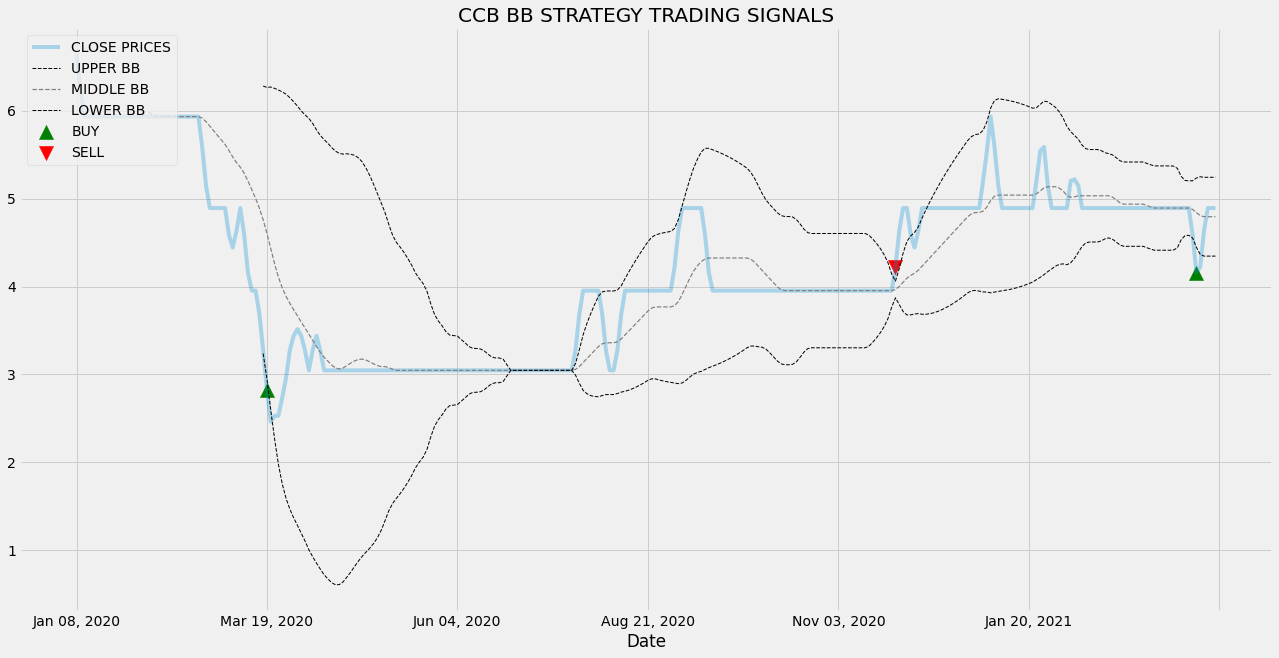

In [5]:
df_final['sma'] = sma(df_final['Predicted Price'], 20)
df_final['upper_bb'], df_final['lower_bb'] = bb(df_final['Predicted Price'], df_final['sma'], 50)
buy_price, sell_price, bb_signal = implement_bb_strategy(df_final['Predicted Price'], df_final['lower_bb'], df_final['upper_bb'])
buy_price.insert(0, None)
sell_price.insert(0, None)
bb_signal.insert(0, None)

df_final['Predicted Price'].plot(label = 'CLOSE PRICES', alpha = 0.3)
df_final['upper_bb'].plot(label = 'UPPER BB', linestyle = '--', linewidth = 1, color = 'black')
df_final['sma'].plot(label = 'MIDDLE BB', linestyle = '--', linewidth = 1.2, color = 'grey')
df_final['lower_bb'].plot(label = 'LOWER BB', linestyle = '--', linewidth = 1, color = 'black')
plt.scatter(df_final.index, buy_price, marker = '^', color = 'green', label = 'BUY', s = 200)
plt.scatter(df_final.index, sell_price, marker = 'v', color = 'red', label = 'SELL', s = 200)
plt.title('CCB BB STRATEGY TRADING SIGNALS')
plt.legend(loc = 'upper left')
plt.show()